In [1]:
# prompt: import dataset from my drive /Assignment2/MLP/Bengaluru_House_Data.csv

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
# from google.colab import drive
# drive.mount('/content/drive')

# Load the dataset from Google Drive
# df = pd.read_csv('/content/drive/My Drive/Bengaluru_House_Data.csv')
df=pd.read_csv('Bengaluru_House_Data.csv')

print(df.describe())
print(df.isnull().sum())
df


               bath       balcony         price
count  13247.000000  12711.000000  13320.000000
mean       2.692610      1.584376    112.565627
std        1.341458      0.817263    148.971674
min        1.000000      0.000000      8.000000
25%        2.000000      1.000000     50.000000
50%        2.000000      2.000000     72.000000
75%        3.000000      2.000000    120.000000
max       40.000000      3.000000   3600.000000
area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64


,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


In [2]:
for column in df.columns:
    if df[column].dtype in [np.float64, np.int64]:
        print(column,"number")
    else:
        print(column,"category")

area_type category
availability category
location category
size category
society category
total_sqft category
bath number
balcony number
price number


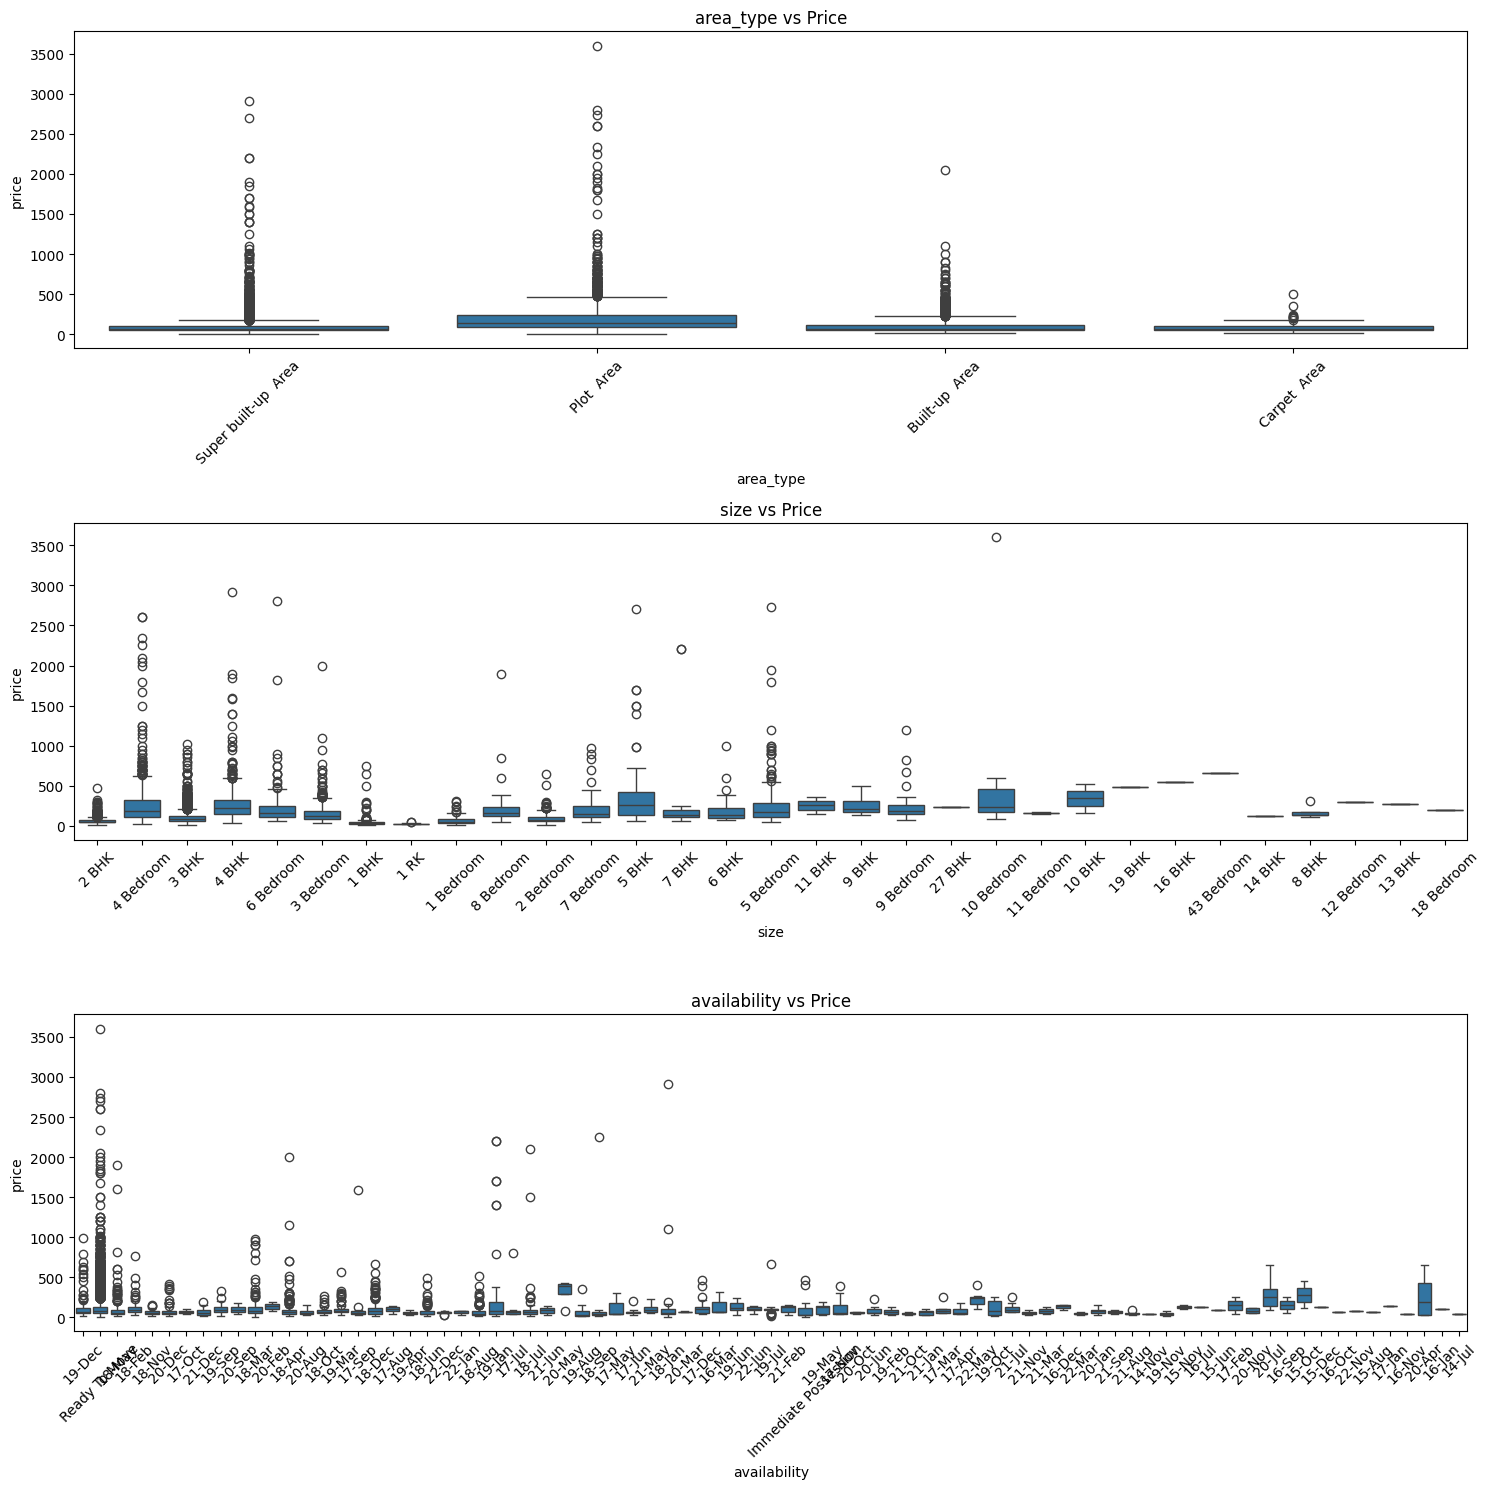

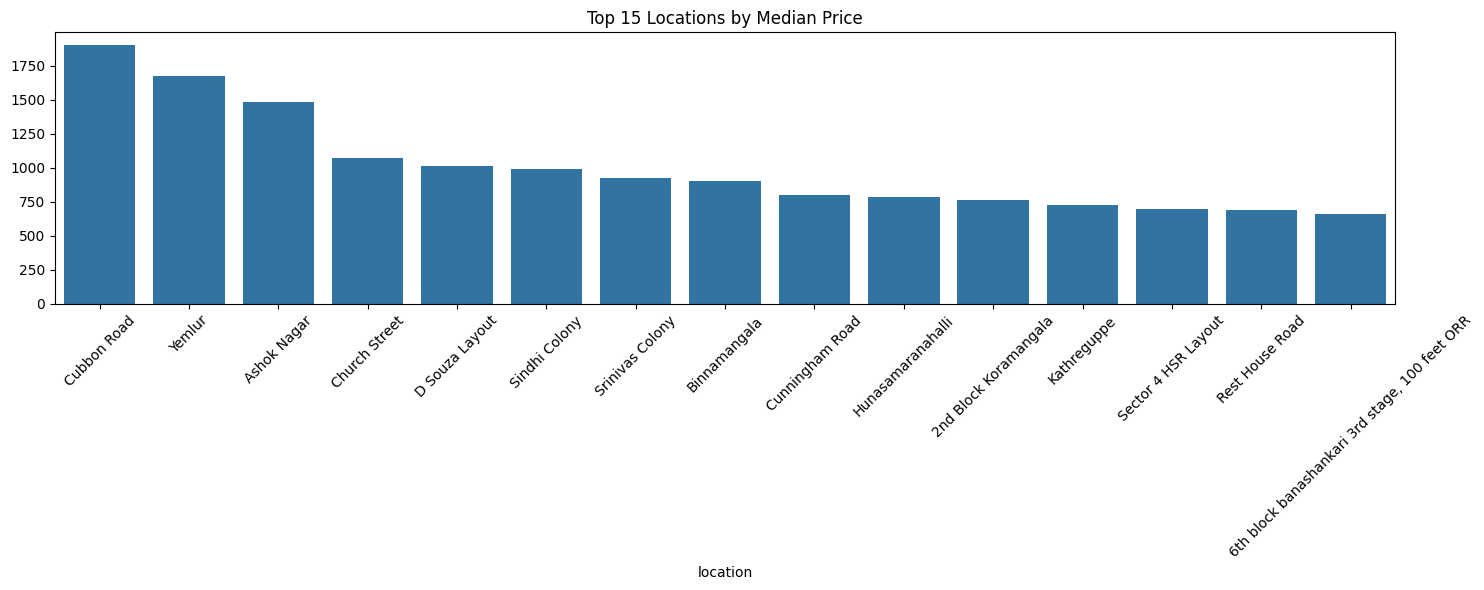

In [4]:
# Box plots for categorical features vs price
categorical_features = ['area_type', 'size', 'availability']

plt.figure(figsize=(15, 15))
for idx, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 1, idx)
    sns.boxplot(data=df, x=feature, y='price')
    plt.xticks(rotation=45)
    plt.title(f'{feature} vs Price')
    plt.tight_layout()
plt.show()

# Location analysis (top 15 locations by median price)
plt.figure(figsize=(15, 6))
location_stats = df.groupby('location')['price'].median().sort_values(ascending=False)[:15]
sns.barplot(x=location_stats.index, y=location_stats.values)
plt.xticks(rotation=45)
plt.title('Top 15 Locations by Median Price')
plt.tight_layout()
plt.show()

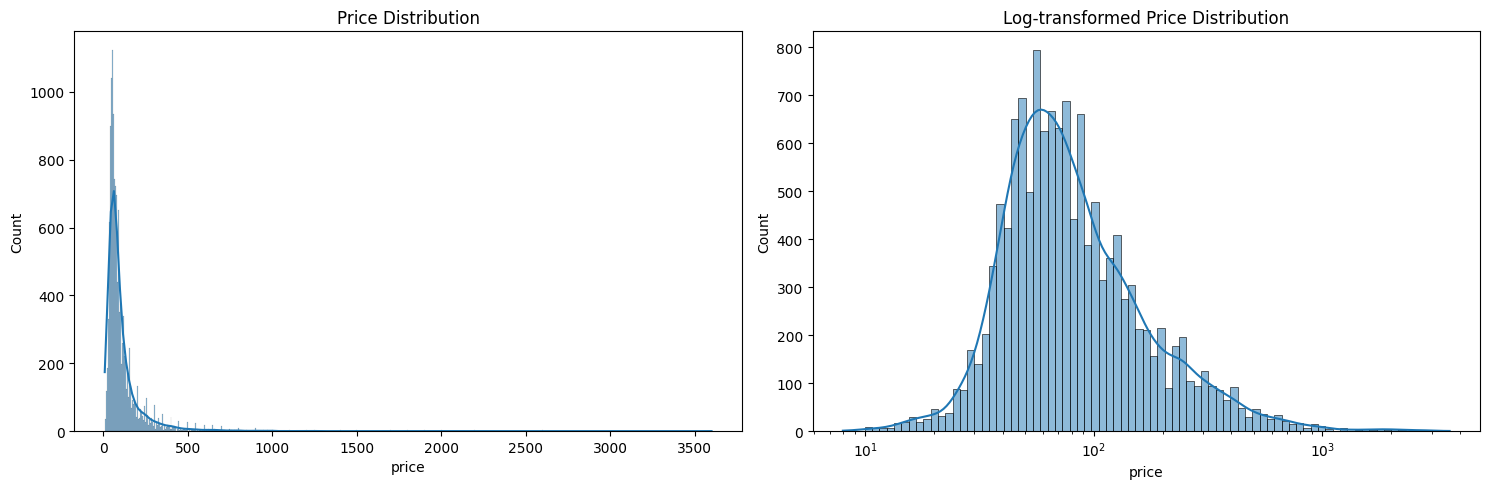

In [5]:
# Price distribution analysis
plt.figure(figsize=(15, 5))

# Price distribution
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='price', kde=True)
plt.title('Price Distribution')

# Log-transformed price distribution
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='price', kde=True, log_scale=True)
plt.title('Log-transformed Price Distribution')

plt.tight_layout()
plt.show()

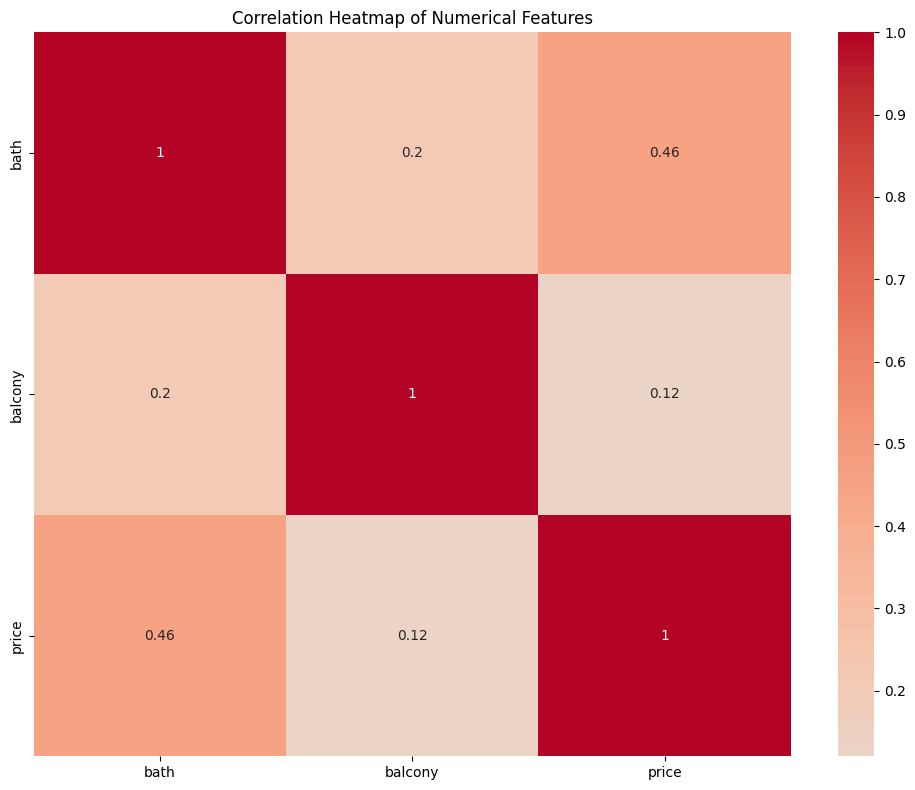

In [7]:
# Create correlation matrix for numerical features
plt.figure(figsize=(10, 8))
numerical_df = df[['bath', 'balcony', 'price']]
correlation_matrix = numerical_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

In [3]:
import re
# Data Cleaning
# Drop columns with excessive missing values
if 'society' in df.columns:
    df.drop(columns=['society'], inplace=True)
# Fill missing values
df['location'].fillna(df['location'].mode()[0], inplace=True)
df['size'].fillna(df['size'].mode()[0], inplace=True)
df['bath'].fillna(df['bath'].median(), inplace=True)
df['balcony'].fillna(df['balcony'].median(), inplace=True)

# Conversion function to encode the total_sqft
# Conversion factors to square feet
conversion_factors = {
    "Sq. Meter": 10.764,  # 1 square meter = 10.764 square feet
    "Sq. Yards": 9,       # 1 square yard = 9 square feet
    "Acres": 43560,       # 1 acre = 43560 square feet
    "Cents": 435.6,       # 1 cent = 435.6 square feet
    "Guntha": 1089,       # 1 guntha = 1089 square feet
    "Grounds": 2400,      # 1 ground = 2400 square feet
    "Perch": 272.25       # 1 perch = 272.25 square feet
}

def convert_sqft(value):
    try:
        value = str(value).strip()  # Ensure value is a string
        
        # Case 1: Direct number (integer or float) (e.g., '1056', '1034.45')
        if re.match(r'^\d+(\.\d+)?$', value):  
            return float(value)  # Convert to float
        
        # Case 2: Range (e.g., '1133 - 1384') → Take the average
        if '-' in value:
            low, high = value.split('-')
            return (float(low.strip()) + float(high.strip())) / 2

        # Case 3: Handling area units (e.g., '4125Perch', '1000Sq. Meter')
        match = re.match(r'([\d.]+)\s*([A-Za-z. ]+)', value)
        if match:
            num, unit = match.groups()
            num = float(num)
            unit = unit.strip()
            
            # Match known area units
            for key in conversion_factors.keys():
                if key in unit:
                    return num * conversion_factors[key]

        # Case 4: If nothing matched, return None
        print(value)
        return None

    except Exception as e:
        print(f"Error converting value: {value}, {e}")
        return None
df['total_sqft'] = df['total_sqft'].apply(convert_sqft).astype(float)
# df.dropna(subset=['total_sqft'], inplace=True)

# Remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

df_cleaned = remove_outliers(df, 'total_sqft')
df_cleaned = remove_outliers(df_cleaned, 'bath')
df_cleaned = remove_outliers(df_cleaned, 'price')
df_cleaned = remove_outliers(df_cleaned, 'balcony')

# One-hot encoding
categorical_features = ['area_type', 'availability', 'location', 'size']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_cats = encoder.fit_transform(df_cleaned[categorical_features])
encoded_df = pd.DataFrame(encoded_cats, columns=encoder.get_feature_names_out(categorical_features))

df_cleaned = df_cleaned.drop(columns=categorical_features).reset_index(drop=True)
df_encoded = pd.concat([df_cleaned, encoded_df], axis=1)

# Standardizing numerical features
features = ['total_sqft', 'bath', 'balcony']
scaler = StandardScaler()
df_encoded[features] = scaler.fit_transform(df_encoded[features])

# Split dataset
train_df, test_df = train_test_split(df_encoded, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

print("cleaned data set shape",df_encoded.shape)
print("length of train set",len(train_df))
print("length of val set",len(val_df))
print("length of test set",len(test_df))

print(df.describe())
print(df.isnull().sum())


/tmp/ipykernel_32082/3754278918.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['location'].fillna(df['location'].mode()[0], inplace=True)
/tmp/ipykernel_32082/3754278918.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inpla

cleaned data set shape (10817, 1191)
length of train set 6922
length of val set 1731
length of test set 2164
         total_sqft          bath       balcony         price
count  1.332000e+04  13320.000000  13320.000000  13320.000000
mean   1.911597e+03      2.688814      1.603378    112.565627
std    1.727690e+04      1.338754      0.803067    148.971674
min    1.000000e+00      1.000000      0.000000      8.000000
25%    1.100000e+03      2.000000      1.000000     50.000000
50%    1.277250e+03      2.000000      2.000000     72.000000
75%    1.680000e+03      3.000000      2.000000    120.000000
max    1.306800e+06     40.000000      3.000000   3600.000000
area_type       0
availability    0
location        0
size            0
total_sqft      0
bath            0
balcony         0
price           0
dtype: int64


In [5]:
(train_df.shape, val_df.shape, test_df.shape)

((6922, 1191), (1731, 1191), (2164, 1191))

In [6]:
# Extract features and target
X_train, y_train = train_df.drop(columns=['price']).values, train_df['price'].values
X_val, y_val = val_df.drop(columns=['price']).values, val_df['price'].values
X_test, y_test = test_df.drop(columns=['price']).values, test_df['price'].values
(X_train.shape, X_val.shape, X_test.shape)

# import numpy as np
# print("NaN in X_train:", np.any(np.isnan(X_train)))
# print("Inf in X_train:", np.any(np.isinf(X_train)))
# print("NaN in y_train:", np.any(np.isnan(y_train)))
# print("Inf in y_train:", np.any(np.isinf(y_train)))

((6922, 1190), (1731, 1190), (2164, 1190))

In [31]:
def mean_squared_error(y_true, y_pred):
    """
    Calculate Mean Squared Error
    """
    return np.mean((y_true.reshape(-1, 1) - y_pred) ** 2)

def r2_score(y_true, y_pred):
    """
    Calculate R² Score
    """
    y_true = y_true.reshape(-1, 1)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import math

class MLPRegressor:
    def __init__(self, input_size, hidden_layers, output_size=1, learning_rate=0.01, activation='relu', optimizer='sgd', batch_size=32):
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.activation = activation
        self.optimizer = optimizer
        self.batch_size = batch_size

        # Initialize weights and biases
        self.weights = []
        self.biases = []

        layer_sizes = [input_size] + hidden_layers + [output_size]
        for i in range(len(layer_sizes) - 1):
           # Xavier initialization for sigmoid/tanh
           if self.activation in ('sigmoid', 'tanh'):
               limit = math.sqrt(6 / (layer_sizes[i] + layer_sizes[i + 1]))
               self.weights.append(np.random.uniform(-limit, limit, size=(layer_sizes[i], layer_sizes[i + 1])))
           # He initialization for ReLU
           else:
               limit = math.sqrt(2 / layer_sizes[i])
               self.weights.append(np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * limit)
           self.biases.append(np.zeros((1, layer_sizes[i + 1])))

    def activation_function(self, x):
        if self.activation == 'relu':
            return np.maximum(0, x)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif self.activation == 'tanh':
            return np.tanh(x)
        return x  # Default to linear

    def activation_derivative(self, a):  # a = activated output
        if self.activation == 'relu':
            return (a > 0).astype(float)
        elif self.activation == 'sigmoid':
            return a * (1 - a)  # where a = sigmoid(z)
        elif self.activation == 'tanh':
            return 1 - a ** 2  # where a = tanh(z)
        return np.ones_like(a)  # Derivative of linear function


    def forward_propagation(self, X):
        activations = [X]
        for i in range(len(self.weights)):
            z = np.dot(activations[-1], self.weights[i]) + self.biases[i]
            a = self.activation_function(z) if i < len(self.weights) - 1 else z  # No activation for output layer
            activations.append(a)
        return activations

    def backward_propagation(self, activations, y):
        m = y.shape[0]
        grads_w = [None] * len(self.weights)
        grads_b = [None] * len(self.biases)

        # Compute output layer error
        dz = activations[-1] - y.reshape(-1, 1)

        for i in reversed(range(len(self.weights))):
            grads_w[i] = np.dot(activations[i].T, dz) / m
            grads_b[i] = np.sum(dz, axis=0, keepdims=True) / m
            if i > 0:
                dz = np.dot(dz, self.weights[i].T) * self.activation_derivative(activations[i])

        return grads_w, grads_b

    def update_weights(self, grads_w, grads_b):
          clip_value = 1  # Set a clipping threshold
          for i in range(len(self.weights)):
              # Add gradient normalization
              grads_w[i] = grads_w[i] / (np.linalg.norm(grads_w[i]) + 1e-8)
              grads_b[i] = grads_b[i] / (np.linalg.norm(grads_b[i]) + 1e-8)
                #clipping to avoid nan values
              np.clip(grads_w[i], -clip_value, clip_value, out=grads_w[i])
              np.clip(grads_b[i], -clip_value, clip_value, out=grads_b[i])
              self.weights[i] -= self.learning_rate * grads_w[i]
              self.biases[i] -= self.learning_rate * grads_b[i]

    def train(self, X, y, epochs=100):
        self.loss_history = []  # Initialize loss history
        for epoch in range(epochs):
            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            X_shuffled, y_shuffled = X[indices], y[indices]

            if self.optimizer == 'batch':  # Batch Gradient Descent
                activations = self.forward_propagation(X_shuffled)
                grads_w, grads_b = self.backward_propagation(activations, y_shuffled)
                self.update_weights(grads_w, grads_b)
                epoch_loss = np.mean((activations[-1] - y_shuffled.reshape(-1, 1))**2)

            elif self.optimizer == 'sgd':  # Stochastic Gradient Descent
                batch_losses = []
                for i in range(X.shape[0]):
                    X_sample = X_shuffled[i:i+1]
                    y_sample = y_shuffled[i:i+1]
                    activations = self.forward_propagation(X_sample)
                    grads_w, grads_b = self.backward_propagation(activations, y_sample)
                    self.update_weights(grads_w, grads_b)
                    batch_losses.append(np.mean((activations[-1] - y_sample.reshape(-1, 1))**2))
                epoch_loss = np.mean(batch_losses)

            elif self.optimizer == 'mini-batch':  # Mini-Batch Gradient Descent
                batch_losses = []
                for i in range(0, X.shape[0], self.batch_size):
                    X_batch = X_shuffled[i:i+self.batch_size]
                    y_batch = y_shuffled[i:i+self.batch_size]
                    activations = self.forward_propagation(X_batch)
                    grads_w, grads_b = self.backward_propagation(activations, y_batch)
                    self.update_weights(grads_w, grads_b)
                    batch_losses.append(np.mean((activations[-1] - y_batch.reshape(-1, 1))**2))
                epoch_loss = np.mean(batch_losses)

            self.loss_history.append(epoch_loss)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")
        return self.loss_history

    def predict(self, X):
        return self.forward_propagation(X)[-1]

if __name__ == "__main__":
    # Train model
    mlp = MLPRegressor(
        input_size=X_train.shape[1],
        output_size=1,
        hidden_layers=[1024, 512, 64],
        learning_rate=0.01,
        activation='relu',
        optimizer='mini-batch',
        batch_size=32
    )
    mlp.train(X_train, y_train, epochs=10)
    
    # Make predictions
    train_predictions = mlp.predict(X_train)
    val_predictions = mlp.predict(X_val)
    test_predictions = mlp.predict(X_test)
    
    # Calculate metrics
    print("\nTraining Metrics:")
    print(f"MSE: {mean_squared_error(y_train, train_predictions):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_train, train_predictions)):.4f}")
    print(f"R²: {r2_score(y_train, train_predictions):.4f}")
    
    print("\nValidation Metrics:")
    print(f"MSE: {mean_squared_error(y_val, val_predictions):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_val, val_predictions)):.4f}")
    print(f"R²: {r2_score(y_val, val_predictions):.4f}")
    
    print("\nTest Metrics:")
    print(f"MSE: {mean_squared_error(y_test, test_predictions):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, test_predictions)):.4f}")
    print(f"R²: {r2_score(y_test, test_predictions):.4f}")


Epoch 0, Loss: 2978.3150

Training Metrics:
MSE: 387.4143
RMSE: 19.6828
R²: 0.6198

Validation Metrics:
MSE: 405.2776
RMSE: 20.1315
R²: 0.6186

Test Metrics:
MSE: 418.3095
RMSE: 20.4526
R²: 0.6090



Training with LR=0.01, Architecture=[64, 32], Activation=relu, Optimizer=sgd
Epoch 0, Loss: 694.4481
Test MSE: 385.9295, RMSE: 19.6451, R²: 0.6393

Training with LR=0.01, Architecture=[64, 32], Activation=relu, Optimizer=mini-batch
Epoch 0, Loss: 3932.0538
Test MSE: 466.2941, RMSE: 21.5938, R²: 0.5642

Training with LR=0.01, Architecture=[64, 32], Activation=relu, Optimizer=batch
Epoch 0, Loss: 5894.9916
Test MSE: 6036.8201, RMSE: 77.6970, R²: -4.6423

Training with LR=0.01, Architecture=[64, 32], Activation=tanh, Optimizer=sgd
Epoch 0, Loss: 1226.8561
Test MSE: 426.1051, RMSE: 20.6423, R²: 0.6017

Training with LR=0.01, Architecture=[64, 32], Activation=tanh, Optimizer=mini-batch
Epoch 0, Loss: 4552.9554
Test MSE: 508.8563, RMSE: 22.5578, R²: 0.5244

Training with LR=0.01, Architecture=[64, 32], Activation=tanh, Optimizer=batch
Epoch 0, Loss: 5878.7042
Test MSE: 5955.1404, RMSE: 77.1696, R²: -4.5659

Training with LR=0.01, Architecture=[64, 32], Activation=sigmoid, Optimizer=sgd
Epoc

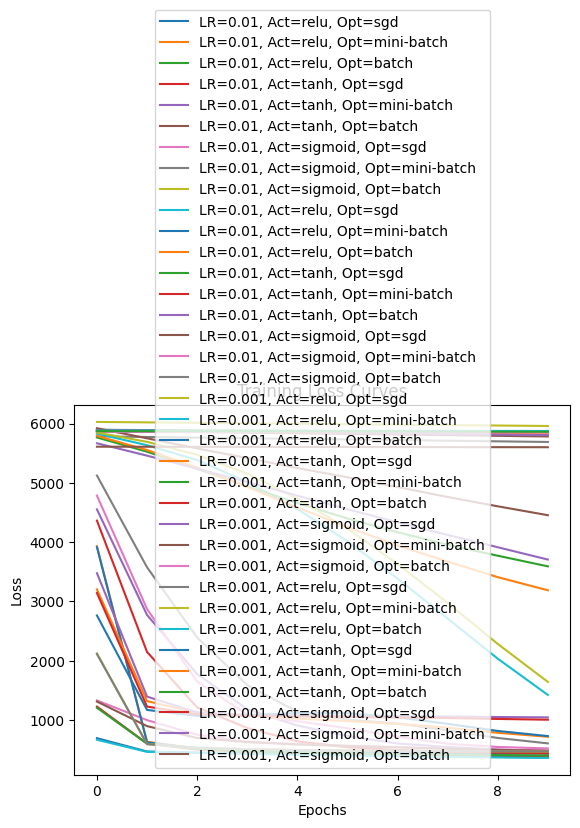

results [{'learning_rate': 0.01, 'architecture': [64, 32], 'activation': 'relu', 'optimizer': 'sgd', 'MSE': np.float64(385.92951631521436), 'RMSE': np.float64(19.645088859947016), 'R2': np.float64(0.6392931198872822)}, {'learning_rate': 0.01, 'architecture': [64, 32], 'activation': 'relu', 'optimizer': 'mini-batch', 'MSE': np.float64(466.2940928608035), 'RMSE': np.float64(21.59384386487972), 'R2': np.float64(0.5641808145261584)}, {'learning_rate': 0.01, 'architecture': [64, 32], 'activation': 'relu', 'optimizer': 'batch', 'MSE': np.float64(6036.820132036916), 'RMSE': np.float64(77.69697633780169), 'R2': np.float64(-4.642280425760837)}, {'learning_rate': 0.01, 'architecture': [64, 32], 'activation': 'tanh', 'optimizer': 'sgd', 'MSE': np.float64(426.1050804247679), 'RMSE': np.float64(20.642312865199187), 'R2': np.float64(0.6017432519085675)}, {'learning_rate': 0.01, 'architecture': [64, 32], 'activation': 'tanh', 'optimizer': 'mini-batch', 'MSE': np.float64(508.8562623190411), 'RMSE': np

In [33]:
# hyperparameter tuning

input_size = X_train.shape[1]
hidden_layers = [64, 32]

# Define hyperparameter values
learning_rates = [0.01, 0.001]
architectures = [[64, 32], [128, 64]]
activations = ['relu', 'tanh', 'sigmoid']
optimizers = ['sgd', 'mini-batch','batch']

# Store results
results = []

# Iterate through all combinations
for lr in learning_rates:
    for arch in architectures:
        for act in activations:
            for opt in optimizers:
                print(f"\nTraining with LR={lr}, Architecture={arch}, Activation={act}, Optimizer={opt}")

                # Initialize and train model
                mlp = MLPRegressor(input_size=input_size,hidden_layers=arch, learning_rate=lr, activation=act, optimizer=opt)
                mlp.train(X_train, y_train, epochs=10)
                # loss_history=np.array(loss_history)

                # Evaluate on test set
                y_pred = mlp.predict(X_test)
                mse = np.mean((y_pred - y_test.reshape(-1, 1)) ** 2)
                rmse = np.sqrt(mse)
                total_variance = np.var(y_test)
                r2_score = 1 - (mse / total_variance)

                # Store results
                results.append({
                    'learning_rate': lr,
                    'architecture': arch,
                    'activation': act,
                    'optimizer': opt,
                    'MSE': mse,
                    'RMSE': rmse,
                    'R2': r2_score
                })
                print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2_score:.4f}")
                # Plot training curve
                plt.plot(range(len(mlp.loss_history)), mlp.loss_history, label=f"LR={lr}, Act={act}, Opt={opt}")
                plt.xlabel('Epochs')
                plt.ylabel('Loss')
                plt.title('Training Loss Curves')
                plt.legend()

# Show training loss curves
plt.show()
print("results",results)

# Convert results to DataFrame and sort by R² score
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='R2', ascending=False)

# Print the best configuration
print("\nBest Configuration:")
print(results_df.iloc[0])


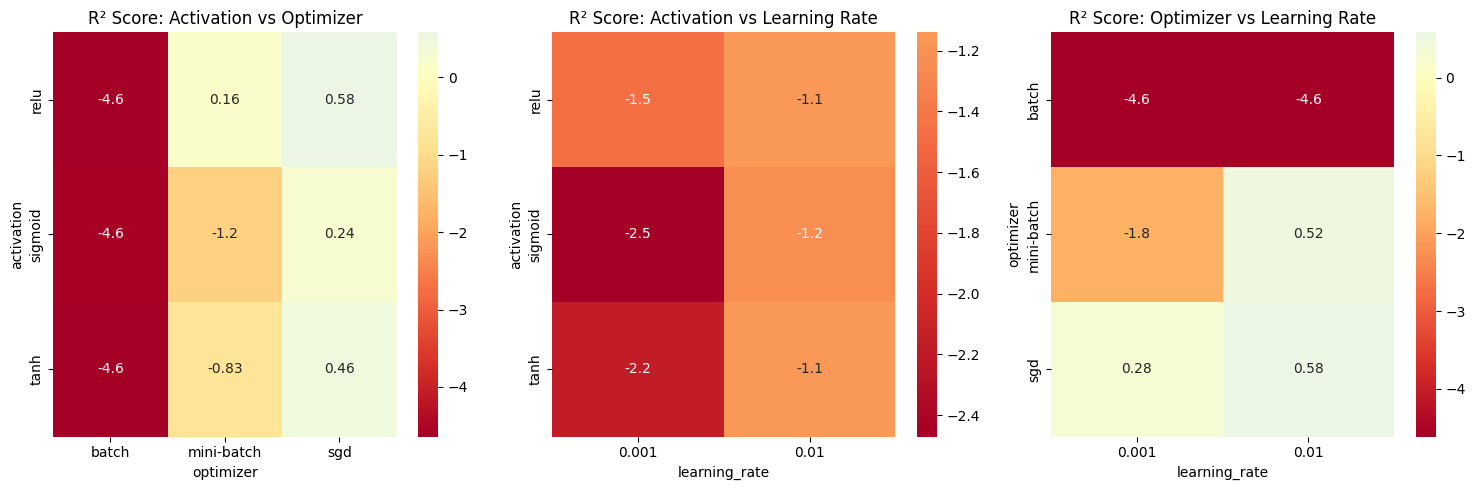

In [35]:
# Create heatmaps to show parameter interactions
plt.figure(figsize=(15, 5))

# 1. Activation vs Optimizer
plt.subplot(1, 3, 1)
pivot_table = results_df.pivot_table(
    values='R2', 
    index='activation',
    columns='optimizer',
    aggfunc='mean'
)
sns.heatmap(pivot_table, annot=True, cmap='RdYlBu', center=0)
plt.title('R² Score: Activation vs Optimizer')

# 2. Activation vs Learning Rate
plt.subplot(1, 3, 2)
pivot_table = results_df.pivot_table(
    values='R2',
    index='activation',
    columns='learning_rate',
    aggfunc='mean'
)
sns.heatmap(pivot_table, annot=True, cmap='RdYlBu', center=0)
plt.title('R² Score: Activation vs Learning Rate')

# 3. Optimizer vs Learning Rate
plt.subplot(1, 3, 3)
pivot_table = results_df.pivot_table(
    values='R2',
    index='optimizer',
    columns='learning_rate',
    aggfunc='mean'
)
sns.heatmap(pivot_table, annot=True, cmap='RdYlBu', center=0)
plt.title('R² Score: Optimizer vs Learning Rate')

plt.tight_layout()
plt.show()

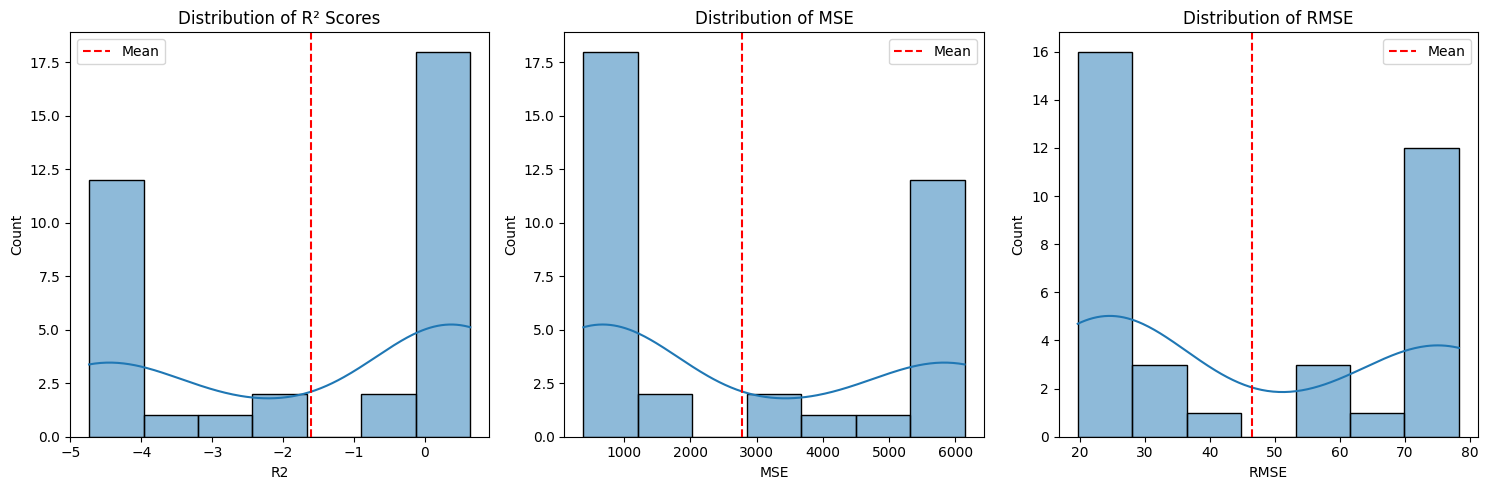

In [36]:
# Distribution of different performance metrics
plt.figure(figsize=(15, 5))

# 1. R² Score Distribution
plt.subplot(1, 3, 1)
sns.histplot(data=results_df, x='R2', kde=True)
plt.title('Distribution of R² Scores')
plt.axvline(results_df['R2'].mean(), color='r', linestyle='--', label='Mean')
plt.legend()

# 2. MSE Distribution
plt.subplot(1, 3, 2)
sns.histplot(data=results_df, x='MSE', kde=True)
plt.title('Distribution of MSE')
plt.axvline(results_df['MSE'].mean(), color='r', linestyle='--', label='Mean')
plt.legend()

# 3. RMSE Distribution
plt.subplot(1, 3, 3)
sns.histplot(data=results_df, x='RMSE', kde=True)
plt.title('Distribution of RMSE')
plt.axvline(results_df['RMSE'].mean(), color='r', linestyle='--', label='Mean')
plt.legend()

plt.tight_layout()
plt.show()

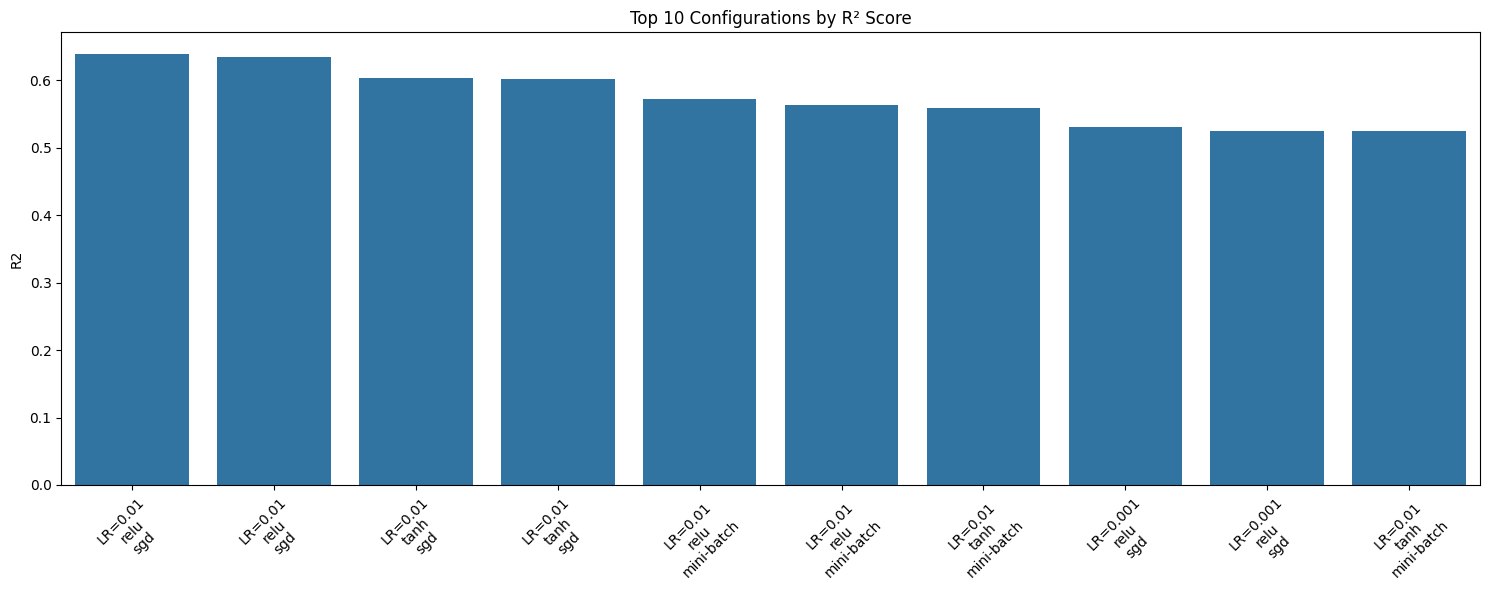


Top 5 Configurations:
    learning_rate architecture activation   optimizer        R2         MSE       RMSE
0            0.01     [64, 32]       relu         sgd  0.639293  385.929516  19.645089
9            0.01    [128, 64]       relu         sgd  0.635398  390.096663  19.750865
12           0.01    [128, 64]       tanh         sgd  0.603506  424.219436  20.596588
3            0.01     [64, 32]       tanh         sgd  0.601743  426.105080  20.642313
10           0.01    [128, 64]       relu  mini-batch  0.571724  458.223715  21.406161


In [37]:
# Plot top 10 configurations
plt.figure(figsize=(15, 6))
top_10 = results_df.nlargest(10, 'R2')

sns.barplot(data=top_10, y='R2', x=range(10))
plt.xticks(range(10), [
    f"LR={row['learning_rate']}\n{row['activation']}\n{row['optimizer']}" 
    for _, row in top_10.iterrows()
], rotation=45)
plt.title('Top 10 Configurations by R² Score')
plt.tight_layout()
plt.show()

# Print detailed information about top 5 configurations
print("\nTop 5 Configurations:")
print(top_10[['learning_rate', 'architecture', 'activation', 'optimizer', 'R2', 'MSE', 'RMSE']].head().to_string())